# Importing necessary libraries

In [46]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
import pickle 

import warnings

# Filter out TqdmWarning and FutureWarning
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet")


# importing dataset and cleaning for inputing into Prophet (META)

In [47]:
solar_cycle = pd.read_csv('../data/solar_cycle.csv')

columns_to_drop = ['smoothed_ssn', 'observed_swpc_ssn', 'smoothed_swpc_ssn', 'smoothed_f10.7']
solar_cycle = solar_cycle.drop(columns=columns_to_drop)

# Convert 'time_tag' column to datetime 
solar_cycle['time_tag'] = pd.to_datetime(solar_cycle['time_tag'])

# Filter the DataFrame to keep rows with 'time_tag' >= '1800-01-01' 
solar_cycle= solar_cycle[solar_cycle['time_tag'] >= '1800-01-01']

In [48]:
# Rename columns to match Prophet's requirements (ds for time and y for target)
solar_cycle.rename(columns={'time_tag': 'ds', 'ssn': 'y'}, inplace=True)

# Sort the DataFrame by 'ds' in chronological order - was already, but just in case
solar_cycle_sorted = solar_cycle.sort_values(by='ds')

# plot the full dataframe, to see solar cycle's pattern (more or less 11 years)
fig = px.line(solar_cycle_sorted, x='ds', y='y', title='Solar Cycle Data')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='SSN')
fig.update_layout(xaxis=dict(tickangle=-45), showlegend=True)
fig.show()

# Predicting next 10 years (2023-2033)

16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing


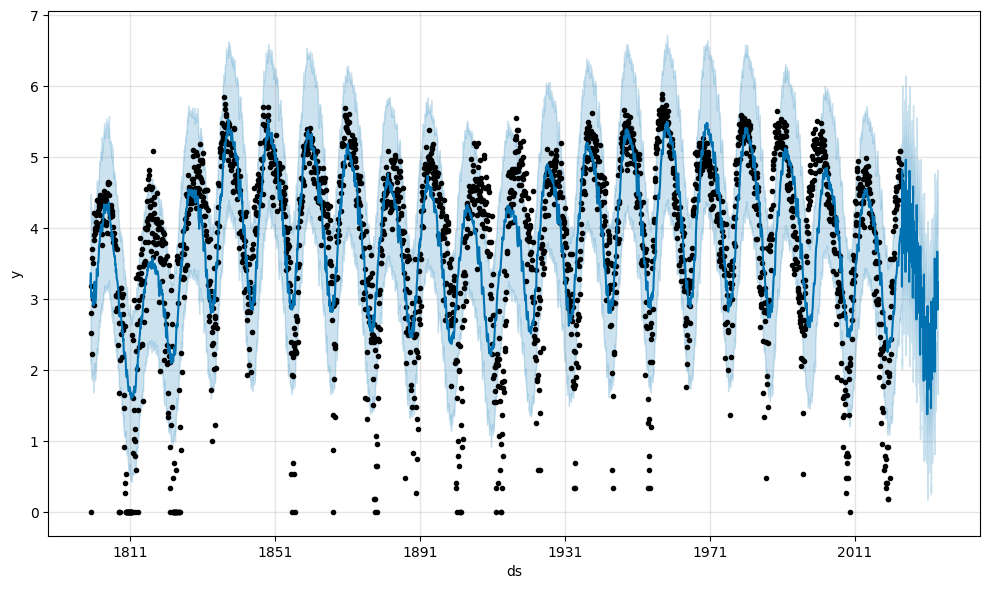

In [49]:

# Create a Prophet model with a seasonality of 11 years to match solar cycles

#ORIGINAL
# model = Prophet(
#     growth='linear',  # Adjust growth type
#     interval_width=0.85,  # Wider prediction intervals
#    # seasonality_mode='multiplicative',
#     changepoint_prior_scale=2000  # Adjust changepoint_prior_scale
# ).add_seasonality(name="11_years", period=11*365, fourier_order=20) #fourier_order=20

#VERSION 2
# model = Prophet(
#     growth='linear',  # Adjust growth type
#     interval_width=0.95,  # Wider prediction intervals
#    # seasonality_mode='multiplicative',
#     changepoint_prior_scale=0.01  # Adjust changepoint_prior_scale
# ).add_seasonality(name="11_years", period=11*365, fourier_order=20) #fourier_order=20

#AFTER HYPERPARAMETERS TUNING
model = Prophet(
    n_changepoints=150,  # Adjust growth type  
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5,  # Adjust changepoint_prior_scale
    holidays_prior_scale=0.2
).add_seasonality(name="11_years", period=11*365, fourier_order=20) #fourier_order=20

# {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


# Rename the columns to match the required format
prophet_df = solar_cycle.copy()

# Log transform the 'y' column
prophet_df["y"] = np.log1p(prophet_df["y"])

# Fit the model
model.fit(prophet_df)

# Create a dataframe for future predictions (next 10 years)
future = model.make_future_dataframe(periods=365*10, freq='D')

# Make predictions
forecast = model.predict(future)

# Plot the results (you can customize the plotting as needed)
fig = model.plot(forecast)
plt.show()




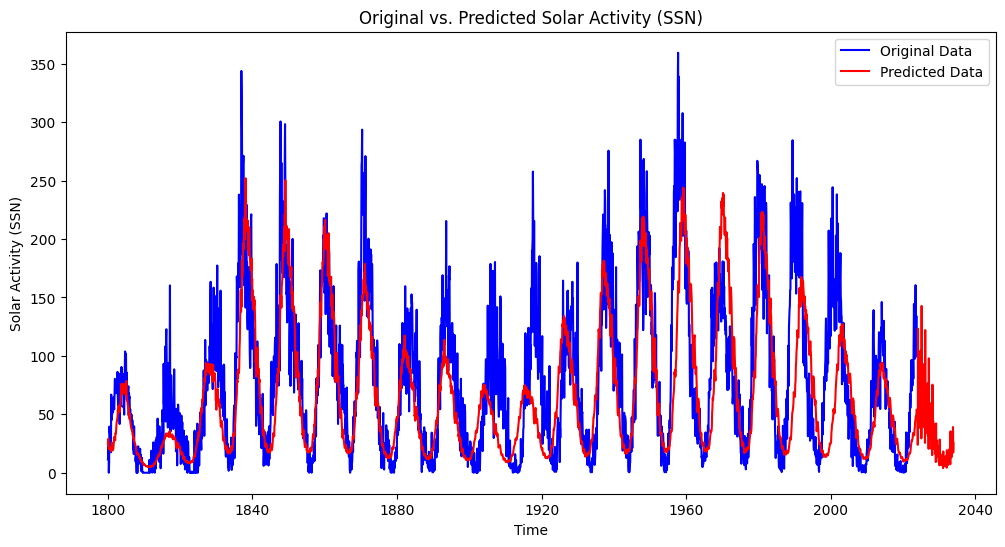

In [50]:
# Apply the exponential function to revert the log transformation
forecast['yhat'] = np.exp(forecast['yhat'])

# Extract the predicted values of 'ds' and the reverted 'yhat' from the forecast dataframe
predicted_y = forecast[['ds', 'yhat']]

# Plot the predicted values alongside the original 'y' values
plt.figure(figsize=(12, 6))
plt.plot(solar_cycle['ds'], solar_cycle['y'], label='Original Data', color='blue')
plt.plot(predicted_y['ds'], predicted_y['yhat'], label='Predicted Data', color='red')
plt.title('Original vs. Predicted Solar Activity (SSN)')
plt.xlabel('Time')
plt.ylabel('Solar Activity (SSN)')
plt.legend()
plt.show()

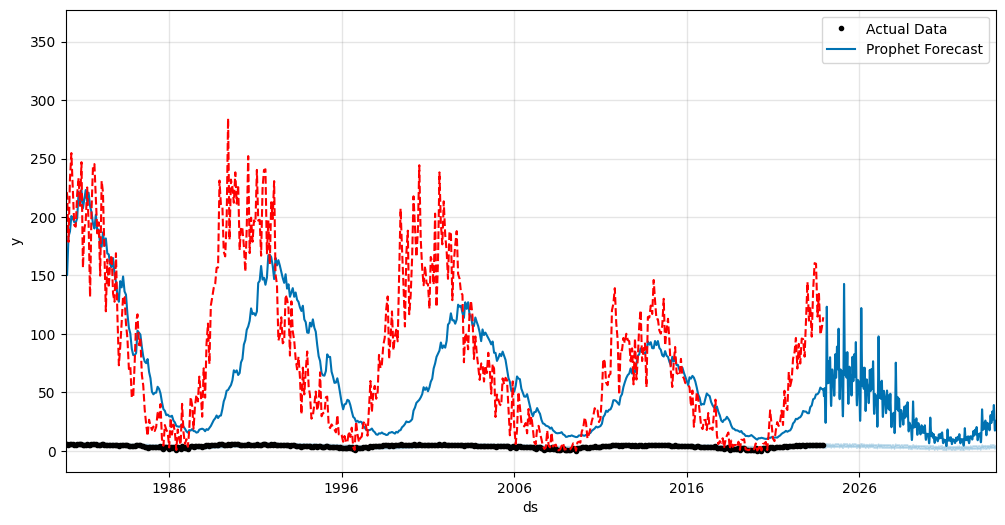

In [51]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))
# Plot Prophet's predictions
model.plot(forecast, ax=ax)

# Plot the actual dataset
plt.plot(solar_cycle['ds'], solar_cycle['y'], label='Actual Data', color='red', linestyle='--')

# Customize the legend
plt.legend(["Actual Data", "Prophet Forecast"])

# Set the x-axis limits to start from January 1980
ax.set_xlim(pd.Timestamp('1980-01-01'), forecast['ds'].max())

plt.show()

# Using train/test split to fine tune Prophet's model

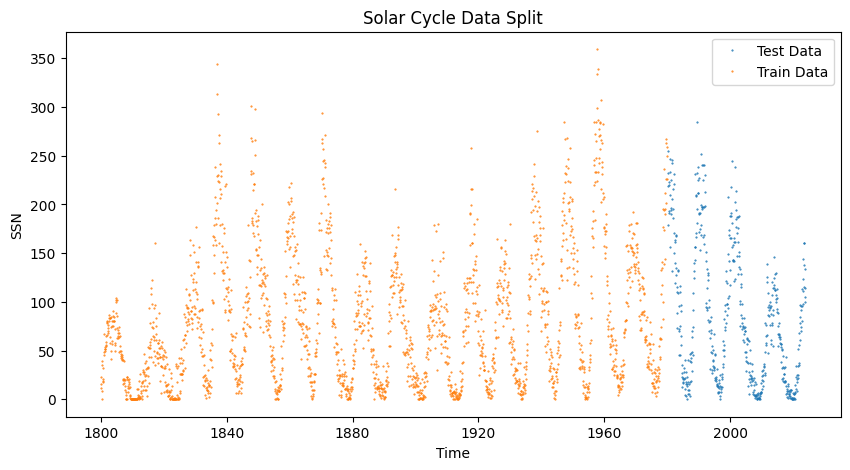

In [53]:
# Define the split date
split_date = '1980-01-01'

# Create train and test DataFrames based on the split date
solar_cycle_train = solar_cycle[solar_cycle['ds'] <= split_date].copy()
solar_cycle_test = solar_cycle[solar_cycle['ds'] > split_date].copy()

# Plot train and test data to visualize the split
plt.figure(figsize=(10, 5))
plt.plot(solar_cycle_test['ds'], solar_cycle_test['y'], label='Test Data', linestyle='', marker='.', ms=1)
plt.plot(solar_cycle_train['ds'], solar_cycle_train['y'], label='Train Data', linestyle='', marker='.', ms=1)
plt.title('Solar Cycle Data Split')
plt.xlabel('Time')
plt.ylabel('SSN')
plt.legend()
plt.show()

In [54]:
# reusing above model on train 

test_model = Prophet(
    growth='linear',  # Adjust growth type
    interval_width=0.95,  # Wider prediction intervals
   # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01  # Adjust changepoint_prior_scale
).add_seasonality(name="11_years", period=11*365, fourier_order=20) #fourier_order=20

test_model.fit(solar_cycle_train)

16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing


In [55]:

solar_cycle_test_predict = test_model.predict(solar_cycle_test)

In [56]:
solar_cycle_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,11_years,11_years_lower,11_years_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-02-01,108.885578,66.526175,248.512583,108.885578,108.885578,43.174032,43.174032,43.174032,46.247391,46.247391,46.247391,3.073359,3.073359,3.073359,0.0,0.0,0.0,155.132969
1,1980-03-01,108.921310,59.930540,255.397548,108.921310,108.921310,42.519572,42.519572,42.519572,48.430017,48.430017,48.430017,5.910445,5.910445,5.910445,0.0,0.0,0.0,157.351326
2,1980-04-01,108.959506,68.636730,262.543369,108.959506,108.959506,44.519152,44.519152,44.519152,52.326473,52.326473,52.326473,7.807321,7.807321,7.807321,0.0,0.0,0.0,161.285978
3,1980-05-01,108.996469,74.814709,258.567483,108.996469,108.996469,48.364838,48.364838,48.364838,57.299713,57.299713,57.299713,8.934874,8.934874,8.934874,0.0,0.0,0.0,166.296182
4,1980-06-01,109.034665,70.510818,263.251057,109.032917,109.034665,53.403019,53.403019,53.403019,60.448967,60.448967,60.448967,7.045949,7.045949,7.045949,0.0,0.0,0.0,169.483633


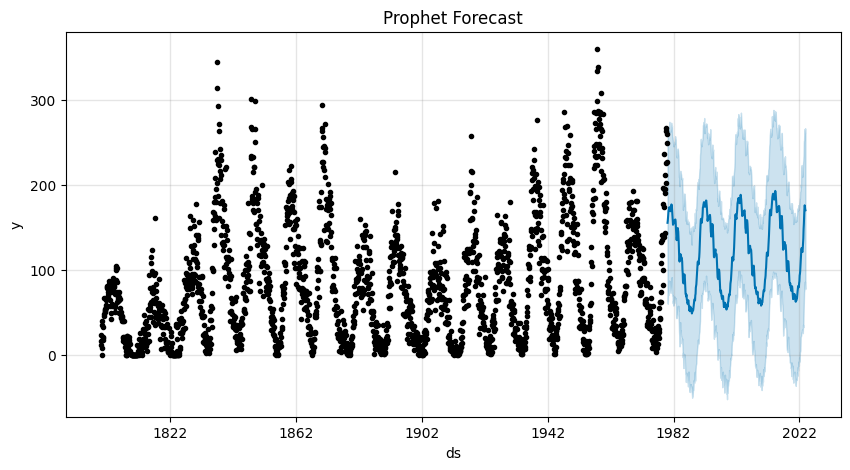

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = test_model.plot(solar_cycle_test_predict, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

    # The black points represent the data points used to train the test_model
    # The blue line represents the forecast
    # The light blue area represents the confidence intervals.

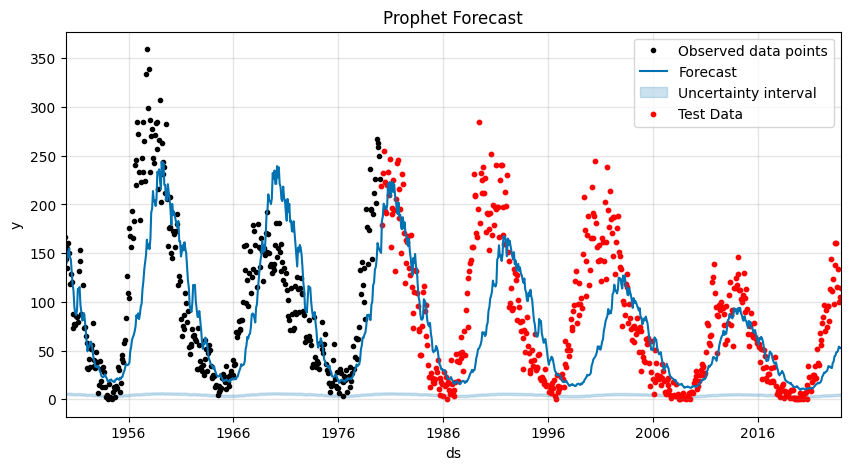

In [58]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the Prophet forecast
test_model.plot(forecast, ax=ax)

# Plot the actual test data
plt.scatter(solar_cycle_test['ds'], solar_cycle_test['y'], label='Test Data', color='red', s=10)

# Set the x-axis limits to start from 1950
ax.set_xlim(pd.Timestamp('1950-01-01'), solar_cycle_test['ds'].max())

# Set the title and legend
ax.set_title('Prophet Forecast')
plt.legend()

# Show the plot
plt.show()

In [59]:
import functions as fun

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) for the test period
mae = mean_absolute_error(solar_cycle_test['y'], solar_cycle_test_predict['yhat'])
mse = mean_squared_error(solar_cycle_test['y'], solar_cycle_test_predict['yhat'])
mape = fun.mean_absolute_percentage_error(solar_cycle_test['y'], solar_cycle_test_predict['yhat'])

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')


Mean Absolute Error (MAE): 63.67
Mean Squared Error (MSE): 5124.71
Mean absolute precentage error (MAPE): inf


c:\Users\antho\Ironhack_workfiles\helios\Notebooks\functions.py:27: RuntimeWarning:

divide by zero encountered in divide



# Looking for the best hyperparameters 

In [60]:
# from sklearn.model_selection import ParameterGrid  
# import random

# # Define your parameter grid
# params_grid = {
#     'seasonality_mode': ['multiplicative', 'additive'],
#     'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'n_changepoints': [100, 150, 200]
# }

# grid = ParameterGrid(params_grid)
# cnt = 0
# for p in grid:
#     cnt = cnt + 1

# print('Total Possible Models', cnt)

# # Initialize a DataFrame to store the results
# results = []

# strt = '1980-01-01'
# end = '2023-12-01'

# for p in grid:
#     test = pd.DataFrame()
#     print(p)
#     random.seed(0)

#     # Create and fit the Prophet model with the current parameters
#     model = Prophet(
#         changepoint_prior_scale=p['changepoint_prior_scale'],
#         holidays_prior_scale=p['holidays_prior_scale'],
#         n_changepoints=p['n_changepoints'],
#         seasonality_mode=p['seasonality_mode'],
#         weekly_seasonality=True,
#         daily_seasonality=True,
#         yearly_seasonality=True
#     )
#     model.fit(solar_cycle_train)  # Assuming you have already defined solar_cycle_train

#     # Make predictions for the test period
#     future = model.make_future_dataframe(periods=len(solar_cycle_test), freq='M')
#     forecast = model.predict(future)

#     # Extract the relevant rows from the forecast for the test period
#     test['ds'] = forecast.loc[(forecast['ds'] > strt) & (forecast['ds'] <= end), 'ds']
#     test['yhat'] = forecast.loc[(forecast['ds'] > strt) & (forecast['ds'] <= end), 'yhat']

#     # Calculate the Mean Absolute Error (MAE) for the test period
#     MAE = mean_absolute_error(solar_cycle_test['y'], test['yhat'])

#     print('Mean Absolute Error (MAE):', MAE)

#     # Append the results to the results list
#     results.append({'MAE': MAE, 'Parameters': p})

# # Create a DataFrame from the results list
# model_parameters = pd.DataFrame(results)

# # Sort the results by MAE in ascending order
# model_parameters = model_parameters.sort_values(by='MAE')

# # Print the best parameters and corresponding MAE
# best_params = model_parameters.iloc[0]['Parameters']
# best_mae = model_parameters.iloc[0]['MAE']
# print('Best Parameters:', best_params)
# print('Best MAE:', best_mae)

In [61]:
# parameters = model_parameters.sort_values(by=['MAE'])
# parameters = parameters.reset_index(drop=True)
# parameters.head()

# Saving the model and associated prediction

In [62]:
with open('../models/prophet/prophet_model_solar_cycles.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)



In [63]:
# Filter rows before 2023-12-31
forecast = forecast[forecast['ds'] > '2023-12-31']

# Filter columns to keep only 'yhat', 'yhat_lower', and 'yhat_upper'
forecast = forecast[['ds', 'yhat']]

# Rename the columns with "prophet_" prefix
forecast.rename(columns={'yhat': 'prophet_ssn'}, inplace=True)

# Reset the index
forecast.reset_index(drop=True, inplace=True)


In [64]:
forecast

,ds,prophet_ssn
0,2024-01-01,52.309410
1,2024-01-02,51.248524
2,2024-01-03,49.881395
3,2024-01-04,48.237691
4,2024-01-05,46.360476
...,...,...
3615,2033-11-24,23.019129
3616,2033-11-25,23.738000
3617,2033-11-26,24.407039
3618,2033-11-27,25.006028


In [65]:
prophet_10y_forecast = fun.group_and_average_by_month(forecast, 'ds')

display(prophet_10y_forecast)

,ds,prophet_ssn
0,2024-01-31,34.632680
1,2024-02-29,92.861541
2,2024-03-31,67.360377
3,2024-04-30,68.591960
4,2024-05-31,48.212925
...,...,...
114,2033-07-31,19.793326
115,2033-08-31,26.866984
116,2033-09-30,29.850240
117,2033-10-31,32.815109


In [66]:

#reseting the date column for future comparison with SARIMA

prophet_10y_forecast['ds'] = prophet_10y_forecast['ds'].dt.strftime('%Y-%m-01')

display(prophet_10y_forecast)

,ds,prophet_ssn
0,2024-01-01,34.632680
1,2024-02-01,92.861541
2,2024-03-01,67.360377
3,2024-04-01,68.591960
4,2024-05-01,48.212925
...,...,...
114,2033-07-01,19.793326
115,2033-08-01,26.866984
116,2033-09-01,29.850240
117,2033-10-01,32.815109


In [67]:
#saving the cleaned and re-indexed dataframe as a CSV for further use
prophet_10y_forecast.to_csv('../data/prophet_10Y_ssn_forecast.csv', index=False)
